In [1]:
import pickle
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
sys.path.append('..')
from utils.util import *
sns.set_theme()
sns.set_style("white")
sns.set_context("talk")
# sns.set_context("paper")

In [2]:
analyze_name1 = 'analyze_credit_assignment'
analyze_name2 = 'analyze_accs'
analyze_name3 = 'calc_ratio'

## Read Norm Gard. Results

In [3]:
analyze_name = analyze_name1

with open('../../results/%s_results_mlp_normgrad.P' %(analyze_name), 'rb') as f:
    mlp_results = pickle.load(f)
# ----------------------
ctx_order = 'first'
ctx_order_str = 'ctxF'
# ----------------------
with open('../../results/%s_%s_results_rnn_normgrad.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnn_results_ctxF = pickle.load(f)
# ----------------------
ctx_order = 'last'
ctx_order_str = 'ctxL'
# ----------------------
with open('../../results/%s_%s_results_rnn_normgrad.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnn_results_ctxL = pickle.load(f)

In [4]:
mlp_ng_runs             = dict_to_list(mlp_results, analyze_name)
rnn_ng_runs_ctxF        = dict_to_list(rnn_results_ctxF, analyze_name)
rnn_ng_runs_ctxL        = dict_to_list(rnn_results_ctxL, analyze_name)
rnn_ng_runs_ctxF.keys()

dict_keys(['grad_ctx', 'grad_f1', 'grad_f2', 'grad_ctx_cong', 'grad_f1_cong', 'grad_f2_cong', 'grad_ctx_incong', 'grad_f1_incong', 'grad_f2_incong'])

## Read accuracies results

In [5]:
analyze_name = analyze_name2

with open('../../results/%s_results_mlp.P' %(analyze_name), 'rb') as f:
    mlp_results = pickle.load(f)
# ----------------------
ctx_order = 'first'
ctx_order_str = 'ctxF'
# ----------------------
with open('../../results/%s_%s_results_rnn.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnn_results_ctxF = pickle.load(f)
# ----------------------
ctx_order = 'last'
ctx_order_str = 'ctxL'
# ----------------------
with open('../../results/%s_%s_results_rnn.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnn_results_ctxL = pickle.load(f)

In [6]:
mlp_acc_runs             = dict_to_list(mlp_results, analyze_name)
rnn_acc_runs_ctxF        = dict_to_list(rnn_results_ctxF, analyze_name)
rnn_acc_runs_ctxL        = dict_to_list(rnn_results_ctxL, analyze_name)
rnn_acc_runs_ctxF.keys()

dict_keys(['train_acc', 'test_acc', 'cong_train_acc', 'incong_train_acc', 'cong_test_acc', 'incong_test_acc'])

## Read Ratio results

In [7]:
analyze_name = analyze_name3

with open('../../results/%s_results_mlp.P' %(analyze_name), 'rb') as f:
    mlp_results = pickle.load(f)
# ----------------------
ctx_order = 'first'
ctx_order_str = 'ctxF'
# ----------------------
with open('../../results/%s_%s_results_rnn.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnn_results_ctxF = pickle.load(f)
# ----------------------
ctx_order = 'last'
ctx_order_str = 'ctxL'
# ----------------------
with open('../../results/%s_%s_results_rnn.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnn_results_ctxL = pickle.load(f)

In [8]:
mlp_r_runs             = dict_to_list(mlp_results, analyze_name)
rnn_r_runs_ctxF        = dict_to_list(rnn_results_ctxF, analyze_name)
rnn_r_runs_ctxL        = dict_to_list(rnn_results_ctxL, analyze_name)
rnn_r_runs_ctxF.keys()

dict_keys(['ratio_embed', 'ratio_hidd'])

In [9]:
val_str = 'ratio_hidd'
ratio_hidds_mlp       = np.asarray(mlp_r_runs[val_str])

ratio_hidds_rnn_ctxF       = np.asarray(rnn_r_runs_ctxF[val_str])
ratio_hidds_rnn_ctxL       = np.asarray(rnn_r_runs_ctxL[val_str])

In [55]:
def runs_to_df(runs_result, ratio_hidds):
        cong_train_accs = np.asarray(runs_result['cong_train_acc'])     
        incong_train_accs = np.asarray(runs_result['incong_train_acc'])
        train_accs = np.asarray(runs_result['train_acc'])

        ratio_cong_incong_train = cong_train_accs / incong_train_accs

        runs, checkpoints = train_accs.shape

        ratio_hidd = pd.DataFrame(ratio_hidds, columns=np.arange(checkpoints), dtype=float) 
        ratio_hidd.insert(0, 'runs', np.arange(runs))
        df_ratio_hidds = pd.melt(ratio_hidd, id_vars=['runs'], var_name='steps', \
                                 value_name='Ratio (cong/incong)')
        df_ratio_hidds['Label'] = 'ratio_dist_hidds'

        ratio_tr = pd.DataFrame(ratio_cong_incong_train, columns=np.arange(checkpoints),dtype=float) 
        ratio_tr.insert(0, 'runs', np.arange(runs))
        df_ratio_cong_incong_acc_tr = pd.melt(ratio_tr, id_vars=['runs'],\
                                             var_name='steps', value_name='Ratio (cong/incong)')
        df_ratio_cong_incong_acc_tr['Label'] = 'ratio_accs_train'

        dfs =  df_ratio_cong_incong_acc_tr, df_ratio_hidds
        return dfs     
        

- each f1, f2, and ctx has shape [n_runs, n_checkpoints]: [20, 21], so the df will have 20*21=420 rows
- if congruency == 'all', df_all will have 420*3=1260 rows (*3 since it is a concat of f1, f2, ctx) 
- if congruency != 'all', df will have (420*3)*2=2520 rows (*3 since it is a concat of f1, f2, ctx, *2 for cong and incong) 

>* dfs_norm_grad = concat_dfs(ctx_order, ctx_order_str)
>* df_all = dfs_norm_grad[(dfs_norm_grad['Congruency']=='all')]
>* df = dfs_norm_grad[(dfs_norm_grad['Congruency']!='all')]
>* df1_all = df[(df['Inputs']=='f1')]
>* df2_all = df[(df['Inputs']=='f2')]
>* dctx_all = df[(df['Inputs']=='ctx')]

- df_merge_all : [420*2]=[840] (*2 is for f1f2 and ctx)
- df_merge: [(420*2)*2]=[1680] (*2 is for f1f2 and ctx, second *2 is for cong and incong)
>* is_df_all = True
>* dfs_norm_grad = concat_dfs(ctx_order, ctx_order_str)
>* df_merge = merge_ng_dfs(dfs_norm_grad, is_df_all)



In [56]:
def merge_ng_dfs(df, is_df_all):
    dfs = []
    if is_df_all:
        df_temp = df[(df['Congruency']=='all')]
    else:
        df_temp = df[(df['Congruency']!='all')]
    # 
    df_f1 = df_temp[df_temp['Inputs'] == 'f1']
    df_f2 = df_temp[df_temp['Inputs'] == 'f2']
    df_ctx = df_temp[df_temp['Inputs'] == 'ctx']
    #
    f1 = np.asarray(df_f1['Norm of Gradients'])
    f2 = np.asarray(df_f2['Norm of Gradients'])
    print(f1.shape, f2.shape)
    f1_f2 = np.mean([f1, f2], axis=0)
    # make a new dataframe with avg of f1 and f2
    df_f1f2 = df_f1.copy()
    df_f1f2['Inputs'] = 'faces'
    df_f1f2['Norm of Gradients'] = f1_f2
    # concat avg of f1f2 with the ctx
    dfs.append(df_f1f2)
    dfs.append(df_ctx)
    df_merge = pd.concat(dfs)

    return df_merge 

In [57]:
def concat_ng_dfs(ctx_order, ctx_order_str, is_df_all, is_merge_faces=True):
    if ctx_order is not None:
        vals_str = eval('rnn_ng_runs_%s' %(ctx_order_str))
    else:
        vals_str = mlp_ng_runs
    dfs = []
    for i, key in enumerate(vals_str.keys()):
        if ctx_order is not None:
            norm_grad = eval('np.asarray(rnn_ng_runs_%s[key])' %(ctx_order_str))
        else:
            norm_grad = np.asarray(mlp_ng_runs[key])
        runs, checkpoints = norm_grad.shape
        df = pd.DataFrame(norm_grad, columns=np.arange(checkpoints)) 
        df.insert(0, 'runs', np.arange(runs))
        df_norm_grad = pd.melt(df, id_vars=['runs'], var_name='steps', value_name="Norm of Gradients")
        strs = key.split('_')
        df_norm_grad['Inputs'] = strs[1]
        if len(strs)<3:
            df_norm_grad['Congruency'] = 'all'
        else:
            df_norm_grad['Congruency'] = strs[2]
        dfs.append(df_norm_grad)
        # ------------
    df_norm_grad = pd.concat(dfs)

    if is_merge_faces:
        dfs_norm_grad = merge_ng_dfs(df_norm_grad, is_df_all)
    else:
        dfs_norm_grad = df_norm_grad.copy()

    return dfs_norm_grad

In [108]:
def plot_norm_grad(dfs, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, \
                        ax, is_df_all, is_accs_plot=True,is_ratio_plot=True):
        
        dfs_norm_grad, df_ratio_cong_incong_acc_tr, df_ratio_hidds = dfs
        mi, mx = -0.001, 0.065
        val_name = "Norm of Gradients"
        ax = sns.lineplot(data=dfs_norm_grad,
                        x="steps", y=val_name, hue="Inputs",\
                        style='Congruency', \
                        markers=True, dashes=False, err_style="bars", ci=68, ax=ax)

        ax2 = ax.twinx()
        mi2, mx2 = 0.5, 2.8
        # threshold = 1
        if is_ratio_plot:
                val_name = "Ratio (cong/incong)"        
                
                ax2 = sns.lineplot(data=df_ratio_hidds,
                                        x="steps", y=val_name, hue="Label", style="Label",
                                        palette=['purple'],
                                        markers="s", dashes=False, err_style="bars", ci=68, ax=ax2)
        if is_accs_plot:
                val_name = "Ratio (cong/incong)"
                # mi2, mx2 = 0.9, 2.7
                ax2 = sns.lineplot(data=df_ratio_cong_incong_acc_tr,
                                x="steps", y=val_name, hue="Label", style="Label",
                                palette=['red'],
                                markers="s", dashes=False, err_style="bars", ci=68, ax=ax2)
        ax2.legend(loc='upper left')                
        # ax2.set_axisbelow(True)
        # ax.set_axisbelow(True)
        ax.set_ylim([mi, mx])
        ax2.set_ylim([mi2, mx2])
        ax.set_title(sub_title)
        ax.legend(loc='upper right')
        # ax2.axhline(y=threshold, color='gray', linewidth=2)

        if ctx_order is not None:
                fig.suptitle('Credit Assignment in %s - Ax %s' %(model_str, ctx_order), fontweight='bold', fontsize='25')
        else:
                fig.suptitle('Credit Assignment in %s' %(model_str), fontweight='bold', fontsize='25')

        plt.tight_layout()
        plt.show()
        if is_df_all:
                fig_str = '%s_norm_gradient_all_results_%s' %(ctx_order_str, mfig_str)
        else:
                fig_str = '%s_norm_gradient_results_%s' %(ctx_order_str, mfig_str)
        fig.savefig(('../../figures/' + fig_str + '.pdf'), 
                        bbox_inches = 'tight', pad_inches = 0)
        fig.savefig(('../../figures/' + fig_str + '.png'), 
                        bbox_inches = 'tight', pad_inches = 0)  
        return ax



# Plot

In [109]:
figx, figy = 12, 6

# MLP

In [110]:
ctx_order, ctx_order_str, model_str, mfig_str, sub_title = None, None, 'MLP', 'normgradmlp', ''
model_name = 'mlp'
df_ratio_cong_incong_acc_tr, df_ratio_hidds = runs_to_df(mlp_acc_runs, ratio_hidds_mlp)

(420,) (420,)


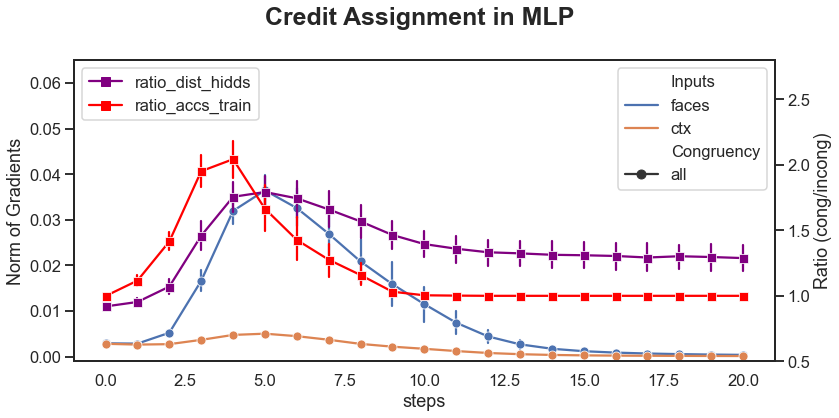

<AxesSubplot:xlabel='steps', ylabel='Norm of Gradients'>

In [111]:
is_df_all=True

fig, ax = plt.subplots(figsize=(figx,figy))
dfs_norm_grad = concat_ng_dfs(ctx_order, ctx_order_str, is_df_all)
dfs = dfs_norm_grad, df_ratio_cong_incong_acc_tr, df_ratio_hidds
plot_norm_grad(dfs, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, is_df_all)

(840,) (840,)


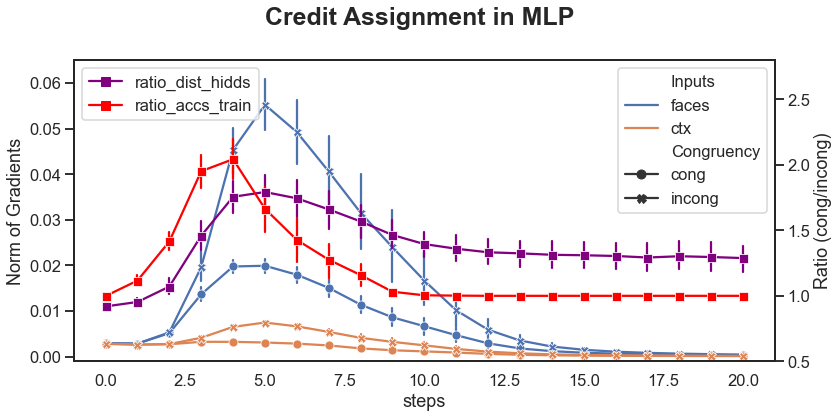

<AxesSubplot:xlabel='steps', ylabel='Norm of Gradients'>

In [112]:
is_df_all=False

fig, ax = plt.subplots(figsize=(figx,figy))
dfs_norm_grad = concat_ng_dfs(ctx_order, ctx_order_str, is_df_all)
dfs = dfs_norm_grad, df_ratio_cong_incong_acc_tr, df_ratio_hidds
plot_norm_grad(dfs, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, is_df_all)

# RNN

In [113]:
ctx_order, ctx_order_str, model_str, mfig_str, sub_title = 'first', 'ctxF', 'RNN', 'normgradrnn', ''
model_name = 'rnn'
df_ratio_cong_incong_acc_tr, df_ratio_hidds = runs_to_df(rnn_acc_runs_ctxF, ratio_hidds_rnn_ctxF)

(420,) (420,)


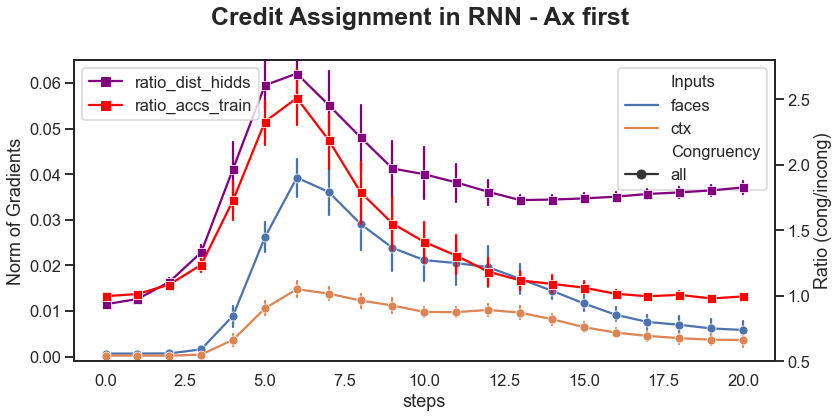

<AxesSubplot:xlabel='steps', ylabel='Norm of Gradients'>

In [114]:
is_df_all=True

fig, ax = plt.subplots(figsize=(figx,figy))
dfs_norm_grad = concat_ng_dfs(ctx_order, ctx_order_str, is_df_all)
dfs = dfs_norm_grad, df_ratio_cong_incong_acc_tr, df_ratio_hidds
plot_norm_grad(dfs, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, is_df_all)

(840,) (840,)


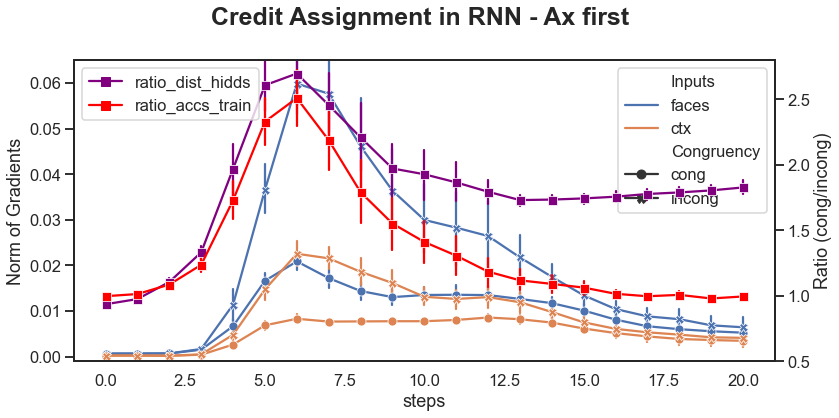

<AxesSubplot:xlabel='steps', ylabel='Norm of Gradients'>

In [115]:
is_df_all=False

fig, ax = plt.subplots(figsize=(figx,figy))
dfs_norm_grad = concat_ng_dfs(ctx_order, ctx_order_str, is_df_all)
dfs = dfs_norm_grad, df_ratio_cong_incong_acc_tr, df_ratio_hidds
plot_norm_grad(dfs, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, is_df_all)

## Ax last

In [116]:
ctx_order, ctx_order_str, model_str, mfig_str, sub_title = 'last', 'ctxL', 'RNN', 'normgradrnn', ''
model_name = 'rnn'
df_ratio_cong_incong_acc_tr, df_ratio_hidds = runs_to_df(rnn_acc_runs_ctxL, ratio_hidds_rnn_ctxL)

(420,) (420,)


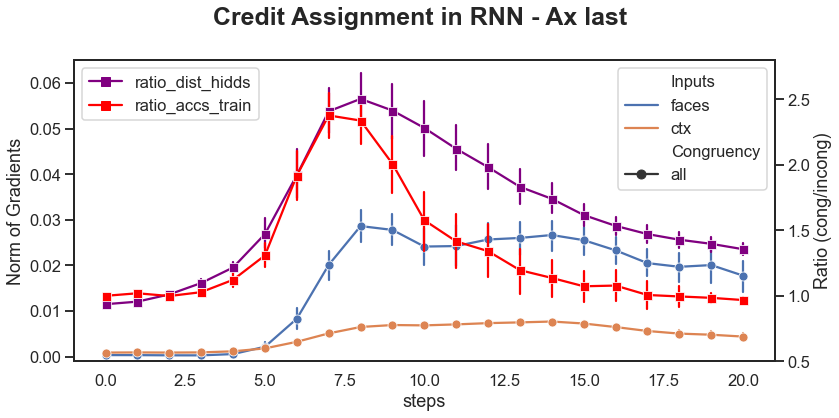

<AxesSubplot:xlabel='steps', ylabel='Norm of Gradients'>

In [117]:
is_df_all=True

fig, ax = plt.subplots(figsize=(figx,figy))
dfs_norm_grad = concat_ng_dfs(ctx_order, ctx_order_str, is_df_all)
dfs = dfs_norm_grad, df_ratio_cong_incong_acc_tr, df_ratio_hidds
plot_norm_grad(dfs, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, is_df_all)

(840,) (840,)


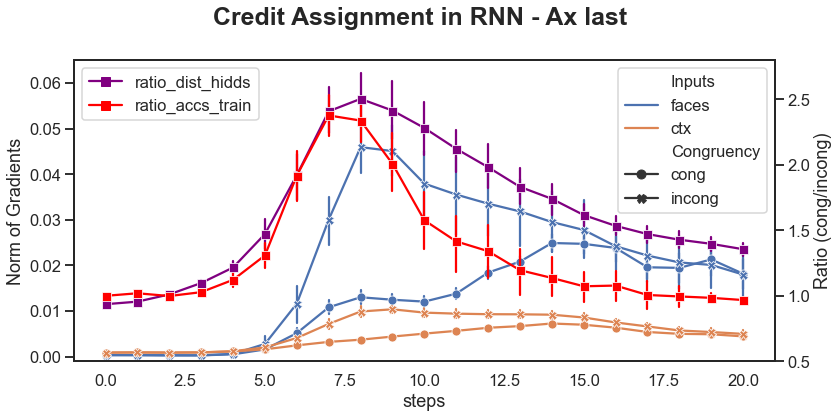

<AxesSubplot:xlabel='steps', ylabel='Norm of Gradients'>

In [118]:
is_df_all=False

fig, ax = plt.subplots(figsize=(figx,figy))
dfs_norm_grad = concat_ng_dfs(ctx_order, ctx_order_str, is_df_all)
dfs = dfs_norm_grad, df_ratio_cong_incong_acc_tr, df_ratio_hidds
plot_norm_grad(dfs, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, is_df_all)